# Paper Plot: Calibration of Estimated Clearsky Values

To get an estimate of instantaneous observed clearsky radiation fluxes is really challenging. The northern Atlantic is a really cloudy place. 

Hence, we use simulated clearsky values to estimate the observed counterpart. The simulation however deviates from the observation which has to be corrected.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot
from nawdex_analysis.plot.legend import legend_renamer, plegend


In [3]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
# rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


## Convert Flux to CRE (Scaling !!!!)

In [5]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [6]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 22, time: 264)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time             (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac            (time, ct, idname) float64 22.11 nan 21.22 ... 8.958 8.958
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 nan 0.0 nan ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 nan 0.0 nan ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 276.2 nan 276.4 ... 272.9 270.9
    swf_up           (time, ct, idname) float64 0.0 nan 0.0 nan ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 nan 0.0 nan ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 274.5 nan 274.3 ... 255.8 255.8
    expname          (time, idname)

## Calculate Mean and STD

In [7]:
daily_mean = rset.sel(ct = ['clear_ocean',]).groupby('time.day').mean('time')

# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = daily_mean.mean('day')

dvar_q = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Calculate Standard Error of Mean

In [9]:
nday = daily_mean.dims['day']
var_sem = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) / np.sqrt( nday )

## Plotting

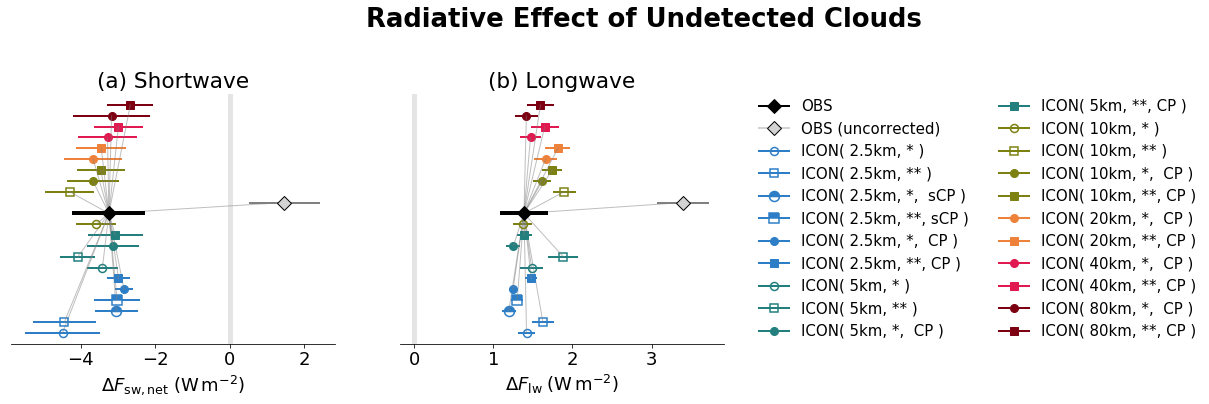

In [18]:
fig, ax = pl.subplots( ncols = 2, figsize = (22, 6))

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'scre_ave', catlist = ['clear_ocean', ], var_err = var_sem)
pl.xlabel('$\Delta F_\mathrm{sw, net} \;(\mathrm{W\,m^{-2}})$')
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.2)
pl.yticks([])
pl.title('(a) Shortwave')#, fontweight = 'bold')
#pl.text(-0.5, 0.1, 'clearsky \n bias', ha = 'center' )

pl.sca(ax[1])
vert_stacked_exp_plot( mvar, 'lcre_ave', catlist = ['clear_ocean', ], var_err = var_sem)
pl.xlabel('$\Delta F_\mathrm{lw} \;(\mathrm{W\,m^{-2}})$')
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.2)
pl.yticks([])
pl.title('(b) Longwave')#, fontweight = 'bold')

pl.suptitle('Radiative Effect of Undetected Clouds', fontsize = 'x-large', fontweight = 'bold')
sns.despine( right = True, left = True)
pl.subplots_adjust( top = 0.78, bottom = 0.2, left = 0.1, right = 0.55)
labels = plegend(ncol = 2, bbox_to_anchor=(2.5, 0.5), frameon = False )
pl.savefig('../pics/calibration_obs-clearsky.png', dpi = 300)